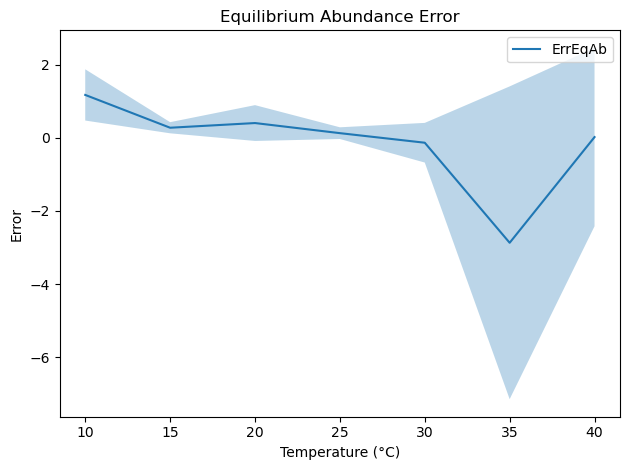

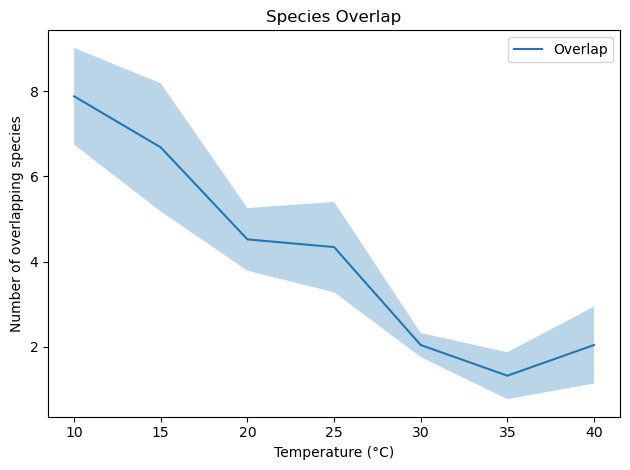

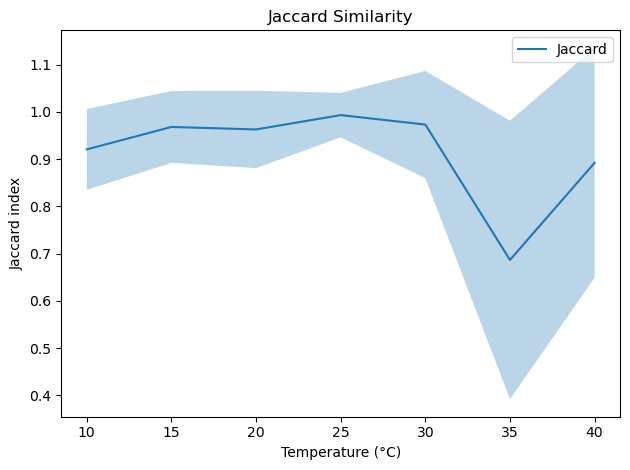

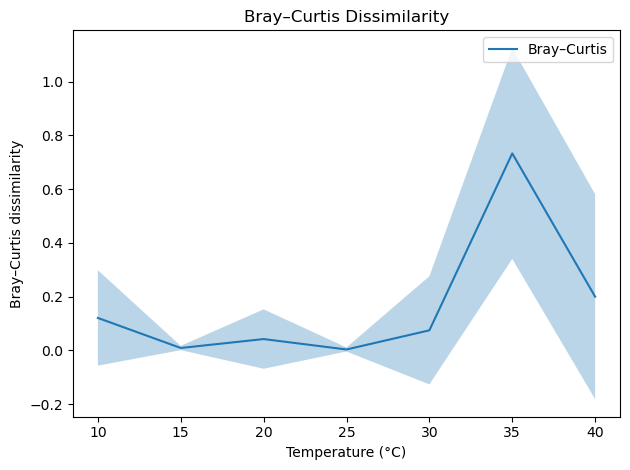

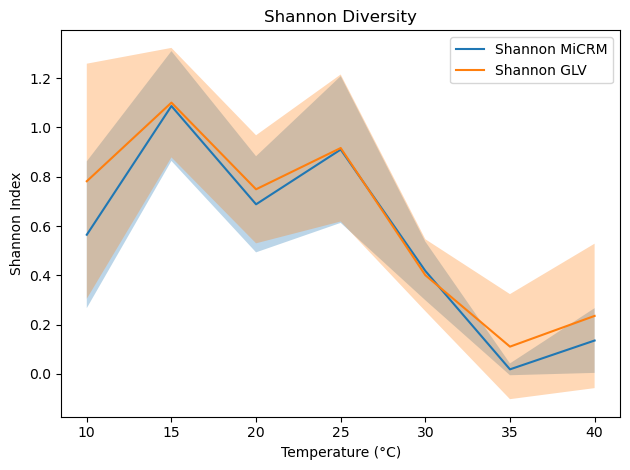

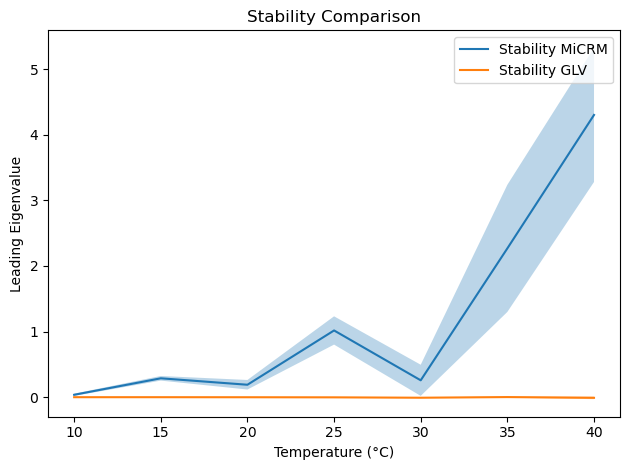

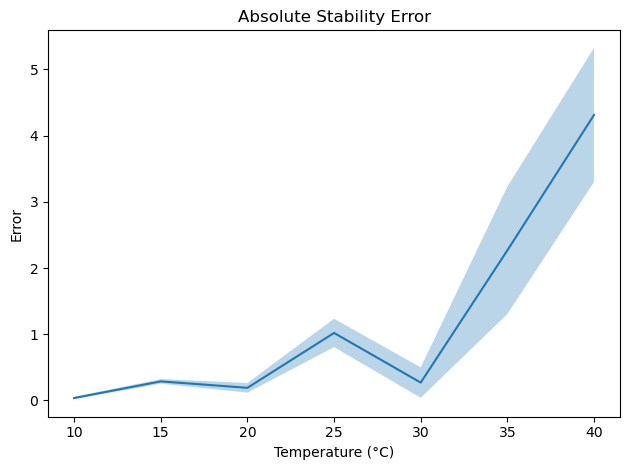

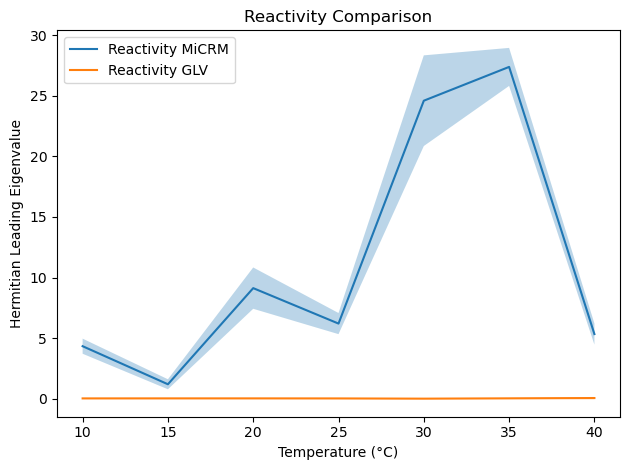

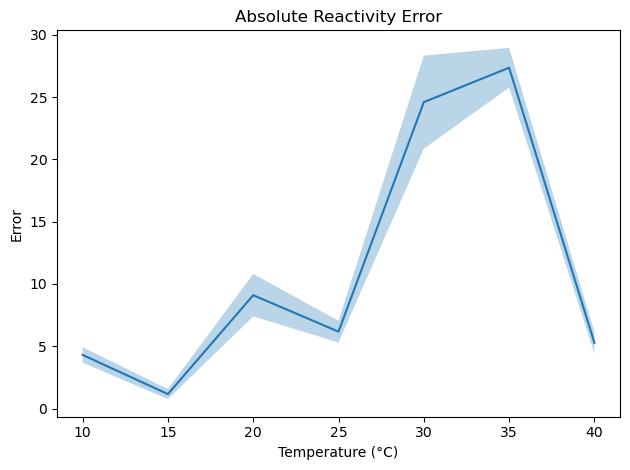

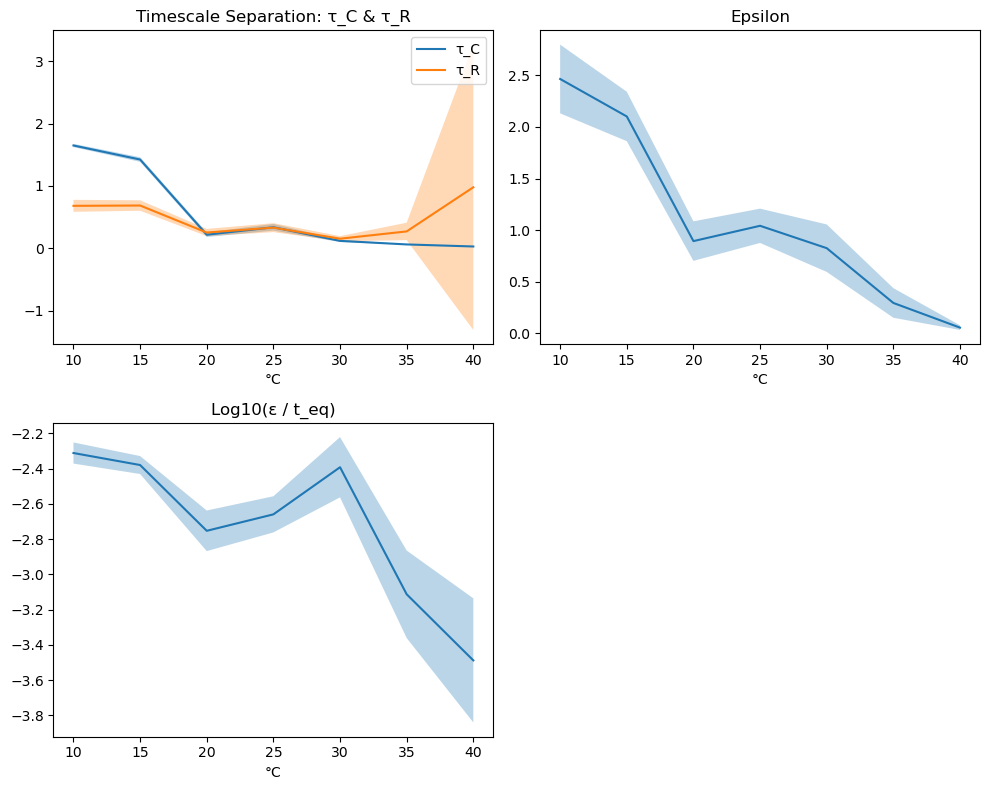

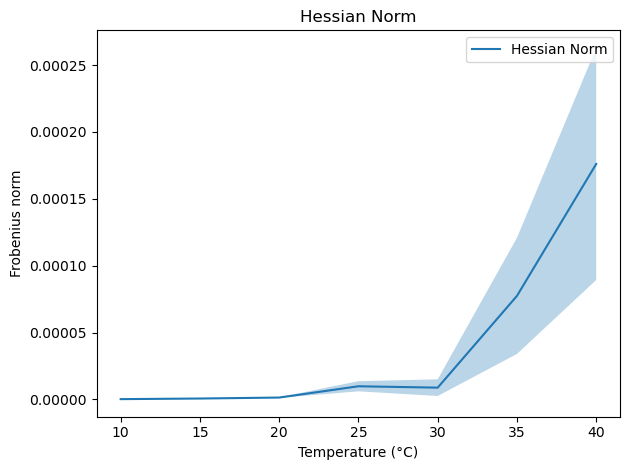

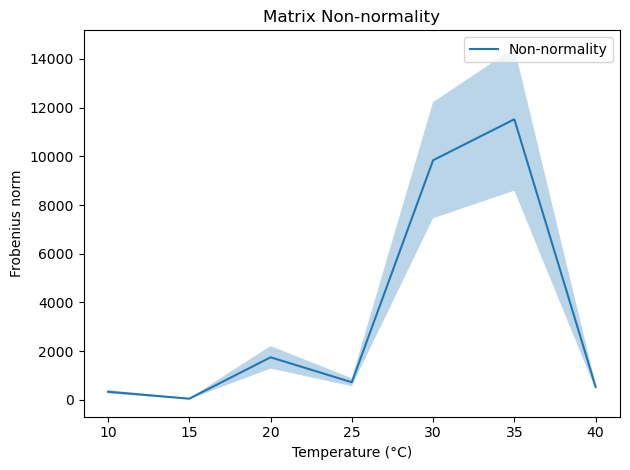

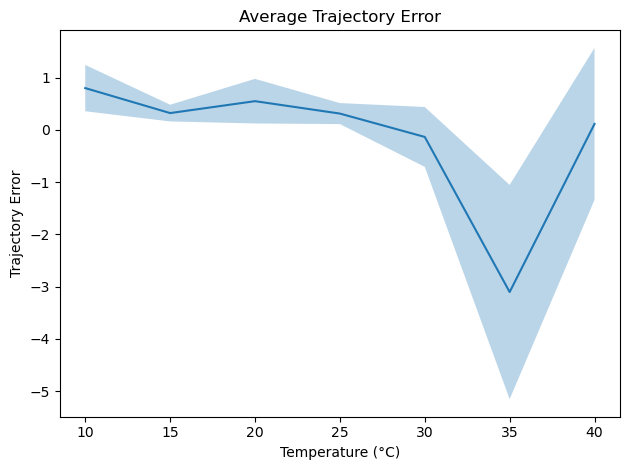

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# ─── USER: adjust these paths to point to your CSVs ─────────────────────────
metrics_fp = "output/metrics_100.csv"
raw_fp     = "output/raw_eq_100.csv"
traj_fp    = "output/traj_100.csv"

# ─── Read in data ───────────────────────────────────────────────────────────
df_met  = pd.read_csv(metrics_fp)
df_raw  = pd.read_csv(raw_fp)
df_traj = pd.read_csv(traj_fp)

# ─── Read in metrics CSV ─────────────────────────
df_met = pd.read_csv(metrics_fp)

# ─── Convert any "(real+0j)" strings to floats ───
complex_cols = ['stab_mi', 'stab_glv', 'react_mi', 'react_glv']
for col in complex_cols:
    if col in df_met.columns:
        df_met[col] = (
            df_met[col]
            .apply(lambda x: ast.literal_eval(x).real if isinstance(x, str) and '+' in x else x)
            .astype(float)
        )


# Convert temperatures to °C
for df in (df_met, df_raw, df_traj):
    if "T_K" in df.columns:
        df["T_C"] = df["T_K"] - 273.15

# ─── Helper to compute mean & SD per T_C ────────────────────────────────────
def summarize(df, cols):
    grouped = df.groupby("T_C")[cols]
    mean = grouped.mean()
    std  = grouped.std()
    return mean, std

# ─── Plotting style function ────────────────────────────────────────────────
def plot_with_error(x, y_mean, y_std, ax, label):
    ax.plot(x, y_mean, label=label)
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.3)

def plot_mean_sd(x, mean, sd, ax, label):
    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean - sd, mean + sd, alpha=0.3)

# ─── 4) ErrEqAb ─────────────────────────────────────────────────────────────
mean_e, sd_e = summarize(df_met, 'ErrEqAb')
fig, ax = plt.subplots()
plot_mean_sd(mean_e.index, mean_e, sd_e, ax, 'ErrEqAb')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Error')
ax.set_title('Equilibrium Abundance Error')
ax.legend()
fig.tight_layout()

# ─── 5) Species overlap ─────────────────────────────────────────────────────
mean_o, sd_o = summarize(df_met, 'overlap')
fig, ax = plt.subplots()
plot_mean_sd(mean_o.index, mean_o, sd_o, ax, 'Overlap')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Number of overlapping species')
ax.set_title('Species Overlap')
ax.legend()
fig.tight_layout()

# ─── 6) Jaccard index ───────────────────────────────────────────────────────
mean_j, sd_j = summarize(df_met, 'jaccard')
fig, ax = plt.subplots()
plot_mean_sd(mean_j.index, mean_j, sd_j, ax, 'Jaccard')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Jaccard index')
ax.set_title('Jaccard Similarity')
ax.legend()
fig.tight_layout()

# ─── 7) Bray–Curtis dissimilarity ───────────────────────────────────────────
mean_bc, sd_bc = summarize(df_met, 'bray_curtis')
fig, ax = plt.subplots()
plot_mean_sd(mean_bc.index, mean_bc, sd_bc, ax, 'Bray–Curtis')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Bray–Curtis dissimilarity')
ax.set_title('Bray–Curtis Dissimilarity')
ax.legend()
fig.tight_layout()

# ─── 3) Shannon diversity (MiCRM vs GLV) ─────────────────────────────────────
mean, std = summarize(df_met, ["shannon_mi", "shannon_lv"])
fig, ax = plt.subplots()
plot_with_error(mean.index, mean["shannon_mi"], std["shannon_mi"], ax, "Shannon MiCRM")
plot_with_error(mean.index, mean["shannon_lv"], std["shannon_lv"], ax, "Shannon GLV")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Shannon Index")
ax.set_title("Shannon Diversity")
ax.legend()
fig.tight_layout()

# ─── 4) Stability (leading eigenvalue) & abs error ───────────────────────────
mean, std = summarize(df_met, ["stab_glv", "stab_mi", "abs_stab_err"])
fig, ax = plt.subplots()
plot_with_error(mean.index, mean["stab_mi"], std["stab_mi"], ax, "Stability MiCRM")
plot_with_error(mean.index, mean["stab_glv"], std["stab_glv"], ax, "Stability GLV")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Leading Eigenvalue")
ax.set_title("Stability Comparison")
ax.legend()
fig.tight_layout()

# ─── 5) Abs stability error ─────────────────────────────────────────────────
fig, ax = plt.subplots()
plot_with_error(mean.index, mean["abs_stab_err"], std["abs_stab_err"], ax, "Abs Stability Error")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Error")
ax.set_title("Absolute Stability Error")
fig.tight_layout()

# ─── 6) Reactivity & abs error ───────────────────────────────────────────────
mean, std = summarize(df_met, ["react_mi", "react_glv", "abs_react_err"])
fig, ax = plt.subplots()
plot_with_error(mean.index, mean["react_mi"], std["react_mi"], ax, "Reactivity MiCRM")
plot_with_error(mean.index, mean["react_glv"], std["react_glv"], ax, "Reactivity GLV")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Hermitian Leading Eigenvalue")
ax.set_title("Reactivity Comparison")
ax.legend()
fig.tight_layout()

fig, ax = plt.subplots()
plot_with_error(mean.index, mean["abs_react_err"], std["abs_react_err"], ax, "Abs Reactivity Error")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Error")
ax.set_title("Absolute Reactivity Error")
fig.tight_layout()

# ─── 7) Timescale separation: τ_C vs τ_R & ε & log10(ε/t_eq) ─────────────────
mean, std = summarize(df_met, ["tau_C", "tau_R", "epsilon", "log10_eps_t_eq"])
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axs = axes.ravel()

plot_with_error(mean.index, mean["tau_C"], std["tau_C"], axs[0], "τ_C")
plot_with_error(mean.index, mean["tau_R"], std["tau_R"], axs[0], "τ_R")
axs[0].set_title("Timescale Separation: τ_C & τ_R")
axs[0].set_xlabel("°C")
axs[0].legend()

plot_with_error(mean.index, mean["epsilon"], std["epsilon"], axs[1], "ε")
axs[1].set_title("Epsilon")
axs[1].set_xlabel("°C")

plot_with_error(mean.index, mean["log10_eps_t_eq"], std["log10_eps_t_eq"], axs[2], "log₁₀(ε / t_eq)")
axs[2].set_title("Log10(ε / t_eq)")
axs[2].set_xlabel("°C")

# remove empty
fig.delaxes(axs[3])
fig.tight_layout()

# ─── 8) Hessian norm ────────────────────────────────────────────────────────
mean_h, sd_h = summarize(df_met, 'hessian_norm')
fig, ax = plt.subplots()
plot_mean_sd(mean_h.index, mean_h, sd_h, ax, 'Hessian Norm')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Frobenius norm')
ax.set_title('Hessian Norm')
ax.legend()
fig.tight_layout()

# ─── 9) Non-normality ───────────────────────────────────────────────────────
mean_nn, sd_nn = summarize(df_met, 'non_normality')
fig, ax = plt.subplots()
plot_mean_sd(mean_nn.index, mean_nn, sd_nn, ax, 'Non-normality')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Frobenius norm')
ax.set_title('Matrix Non-normality')
ax.legend()
fig.tight_layout()

# ─── 9) Trajectory error (ErrTraj) ───────────────────────────────────────────
mean_traj, std_traj = summarize(df_traj, ["ErrTraj"])
fig, ax = plt.subplots()
plot_with_error(mean_traj.index, mean_traj["ErrTraj"], std_traj["ErrTraj"], ax, "ErrTraj")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Trajectory Error")
ax.set_title("Average Trajectory Error")
fig.tight_layout()

# ─── Finally, show all figures ───────────────────────────────────────────────
plt.show()
